In [ ]:
from monolayer_tracking.segmented_comprehension import Stack
import numpy as np
import matplotlib.pyplot as plt
import trackpy as tp
import pandas as pd
from tqdm.notebook import tqdm
plt.style.use('dark_background')

In [2]:
scale=1/5.7926
gastruloid=Stack('F:/Amanda/ZO-1/segmented/zo1_48hr_circle_1_MAX/', scale=scale)

# Density vs. r

In [18]:
shape=np.array(gastruloid.frames[0].masks.shape)
center=shape/2*scale # image center, taken as circle center

positions=gastruloid.centroids().copy()
positions[['x','y']]*=scale

# calculate areas by counting mask pixels
areas=np.concatenate([np.unique(frame.masks, 0, return_counts=True)[1][1:]*frame.scale**2
                      for frame in tqdm(gastruloid.frames)])
positions['area']=areas

positions['r']=np.linalg.norm(positions[['x','y']]-center, axis=1)

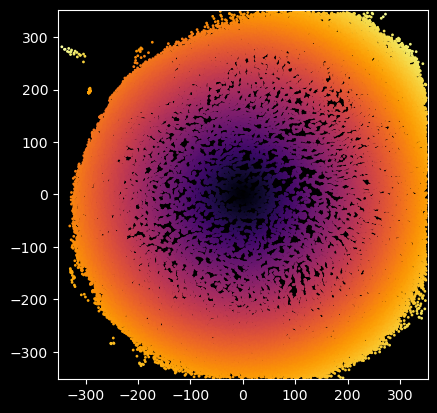

In [24]:
positions_1=positions[positions.frame<50]
plt.scatter(positions_1['x']-center[1],positions_1['y']-center[0], c=positions_1['r'], cmap='inferno', s=1)
plt.xlim(-center[1],center[1])
plt.ylim(-center[0],center[0])
plt.gca().set_aspect('equal')

Text(0, 0.5, 'mean cell area (square microns)')

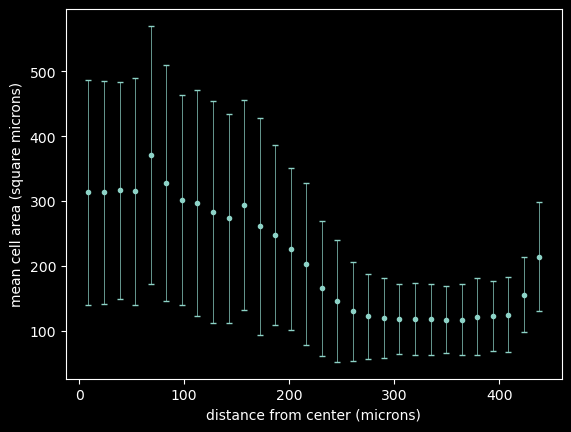

In [25]:
radial_area=positions_1.groupby(pd.cut(positions_1['r'], bins=30))['area'].agg(['mean','std'])
bin_centers=[cat.mid for cat in radial_area.index.values]
plt.errorbar(bin_centers, radial_area['mean'], yerr=radial_area['std'], fmt='.', capsize=2, linewidth=0.5)
plt.xlabel('distance from center (microns)')
plt.ylabel('mean cell area (square microns)')

# Speed vs. r

In [34]:
t=tp.link(positions, search_range=5.5, memory=3)
#t['area']=areas
t_filtered=tp.filter_stubs(t, 3)
t_corrected=tp.subtract_drift(t_filtered, tp.compute_drift(t_filtered))

gastruloid.tracked_centroids=t_corrected.reset_index(drop=True)

In [37]:
if not hasattr(gastruloid, 'velocities'):
    gastruloid.get_velocities()

v=gastruloid.velocities[gastruloid.velocities.frame<70].copy()
# get distances from center. 5.7926 pixels per micron
v['r']=np.linalg.norm(v[['x','y']]-center, axis=1)
#v['v']/=5.7926

Text(0, 0.5, 'speed (microns/frame)')

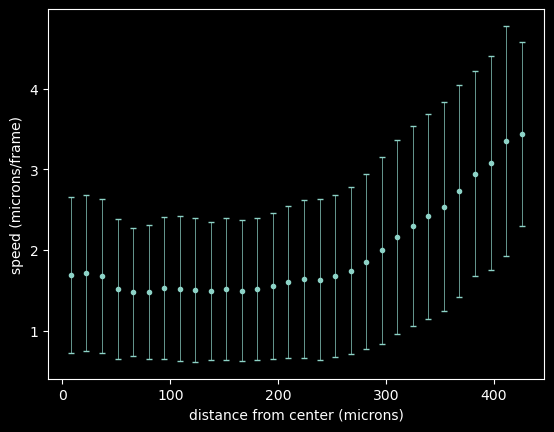

In [42]:
radial_v=v.groupby(pd.cut(v['r'], bins=30))['v'].agg(['mean','std'])
bin_centers=[cat.mid for cat in radial_v.index.values]
plt.errorbar(bin_centers, radial_v['mean'], yerr=radial_v['std'], fmt='.', capsize=2, linewidth=0.5)
plt.xlabel('distance from center (microns)')
plt.ylabel('speed (microns/frame)')

# $\theta_v$ vs. r

In [62]:
v['theta_r']=np.arctan2(*np.array((v[['y','x']]-center)).T)
v['centered_theta']=np.abs(v['theta']-v['theta_r'])
radial_theta=v.groupby(pd.cut(v['r'], bins=50))['centered_theta'].agg(['mean','std'])

<Axes: >

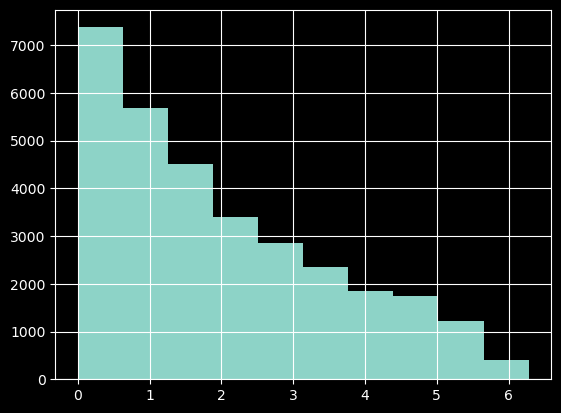

In [65]:
v[v.r<200]['centered_theta'].hist()

<Axes: >

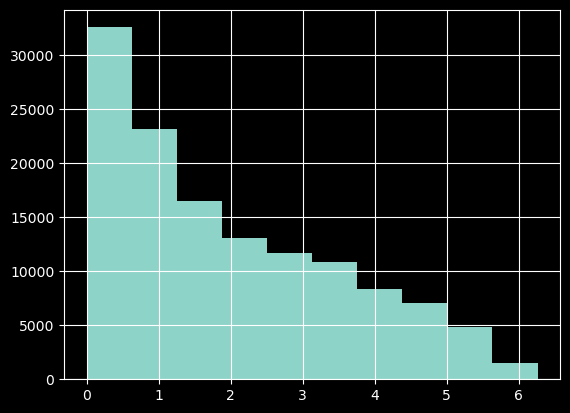

In [66]:
v[v.r>200]['centered_theta'].hist()

Text(0, 0.5, 'speed (microns/frame)')

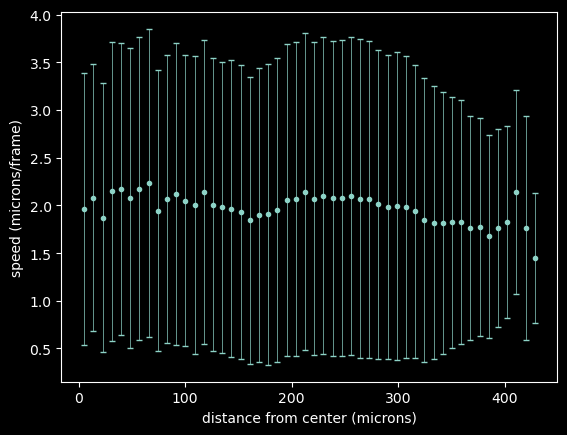

In [63]:
bin_centers=[cat.mid for cat in radial_theta.index.values]
plt.errorbar(bin_centers, radial_theta['mean'], yerr=radial_theta['std'], fmt='.', capsize=2, linewidth=0.5)
plt.xlabel('distance from center (microns)')
plt.ylabel('speed (microns/frame)')

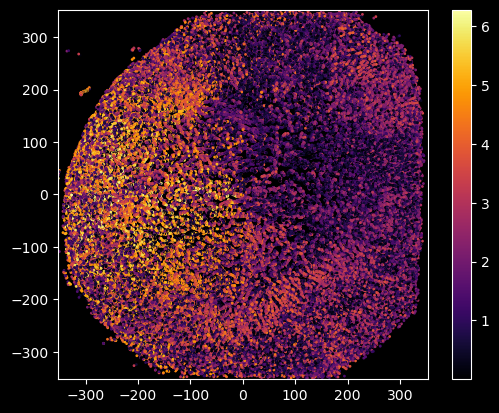

In [67]:
plt.scatter(v['x']-center[1],v['y']-center[0], c=v['centered_theta'], cmap='inferno', s=1)
plt.xlim(-center[1],center[1])
plt.ylim(-center[0],center[0])
plt.gca().set_aspect('equal')
plt.colorbar()
# asymmetry indicates collective migration. uh oh, maybe I can't set a fixed center point.